In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/archive1.zip

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

---

In [ ]:
labels = ['glioma','meningioma','notumor','pituitary']

In [ ]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 300/300 [00:00<00:00, 481.88it/s]


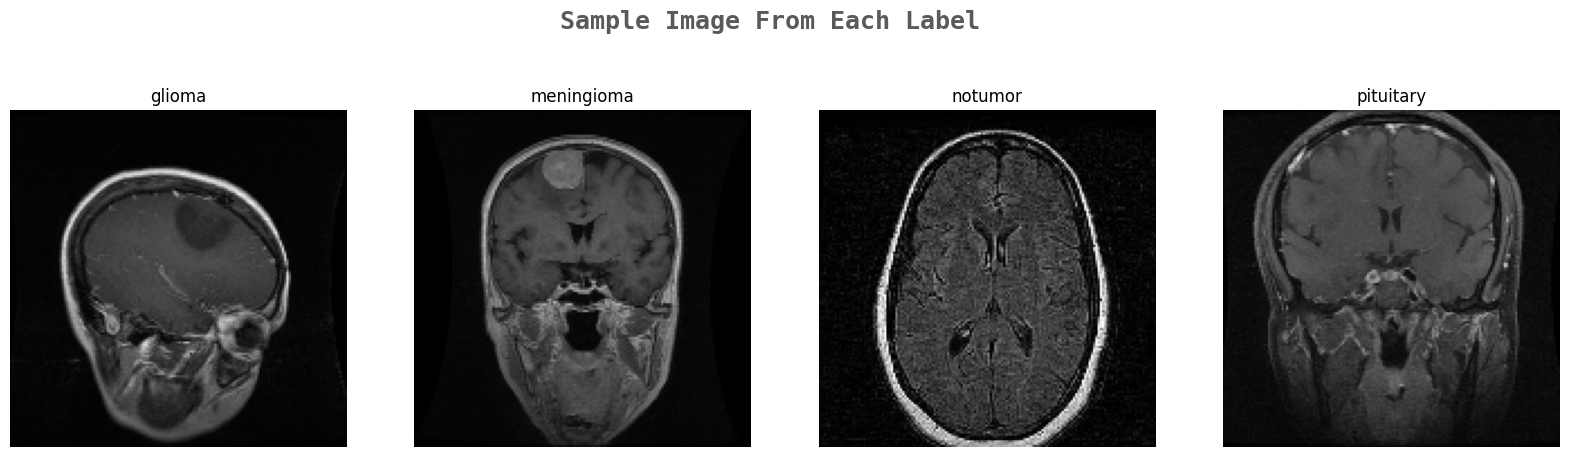

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [ ]:
X_train.shape

(7023, 150, 150, 3)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

Performing **One Hot Encoding** on the labels after converting it into numerical values:

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

---

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Average
model1 = load_model('/content/drive/MyDrive/Colab Notebooks/AI/final-MobileNet-new.h5')
model2 = load_model('/content/drive/MyDrive/Colab Notebooks/AI/final-VGG-new.h5')
model3 = load_model('/content/drive/MyDrive/Colab Notebooks/AI/final-resnet-new.h5')
model1._name = "model1"
model2._name = "model2"
model3._name = "model3"
input_tensor = Input(shape=(150, 150, 3))
output_tensor1 = model1(input_tensor)
output_tensor2 = model2(input_tensor)
output_tensor3 = model3(input_tensor)
output_tensor = Average()([output_tensor1, output_tensor2, output_tensor3])
model = Model(inputs=input_tensor, outputs=output_tensor)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 model1 (Functional)         (None, 4)                    5146180   ['input_7[0][0]']             
                                                                                                  
 model2 (Functional)         (None, 4)                    1681645   ['input_7[0][0]']             
                                                          2                                       
                                                                                                  
 model3 (Functional)         (None, 4)                    2726234   ['input_7[0][0]']       

---

In [ ]:
from tensorflow.keras.layers import Reshape

# Concatenate the outputs of the four models
concatenated_output = Concatenate(axis=-1)([output_tensor1, output_tensor2, output_tensor3])

# Reshape the concatenated output tensor to have the appropriate shape
reshaped_output = Reshape((12,))(concatenated_output)

# Add additional layers as needed
x = Dense(1024, activation='relu')(reshaped_output)
x = Dense(512, activation='relu')(x)

# Output layer with the correct number of classes
num_classes = 4  # Assuming you have four classes
output_tensor = Dense(num_classes, activation='softmax')(x)

# Create the combined model
model = Model(inputs=input_tensor, outputs=output_tensor)

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 model1 (Functional)         (None, 4)                    5146180   ['input_8[0][0]']             
                                                                                                  
 model2 (Functional)         (None, 4)                    1681645   ['input_8[0][0]']             
                                                          2                                       
                                                                                                  
 model3 (Functional)         (None, 4)                    2726234   ['input_8[0][0]']       

In [ ]:
# initial optimizer
optimizer_initial = 'SGD'
# compile the model
model.compile(optimizer=optimizer_initial,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =25, verbose=1, batch_size=8,
                   callbacks=[reduce_lr])

Epoch 1/25
711/711 [==============================] - 104s 66ms/step - loss: 0.2797 - accuracy: 0.9882 - val_loss: 0.0393 - val_accuracy: 0.9921 - lr: 0.0100
Epoch 2/25
711/711 [==============================] - 43s 61ms/step - loss: 0.0238 - accuracy: 0.9977 - val_loss: 0.0241 - val_accuracy: 0.9937 - lr: 0.0100
Epoch 3/25
711/711 [==============================] - 44s 61ms/step - loss: 0.0101 - accuracy: 0.9991 - val_loss: 0.0164 - val_accuracy: 0.9937 - lr: 0.0100
Epoch 4/25
711/711 [==============================] - 45s 63ms/step - loss: 0.0064 - accuracy: 0.9995 - val_loss: 0.0169 - val_accuracy: 0.9953 - lr: 0.0100
Epoch 5/25
711/711 [==============================] - 44s 62ms/step - loss: 0.0037 - accuracy: 0.9998 - val_loss: 0.0180 - val_accuracy: 0.9953 - lr: 0.0100
Epoch 6/25
711/711 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 0.9998
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
711/711 [==============================] -

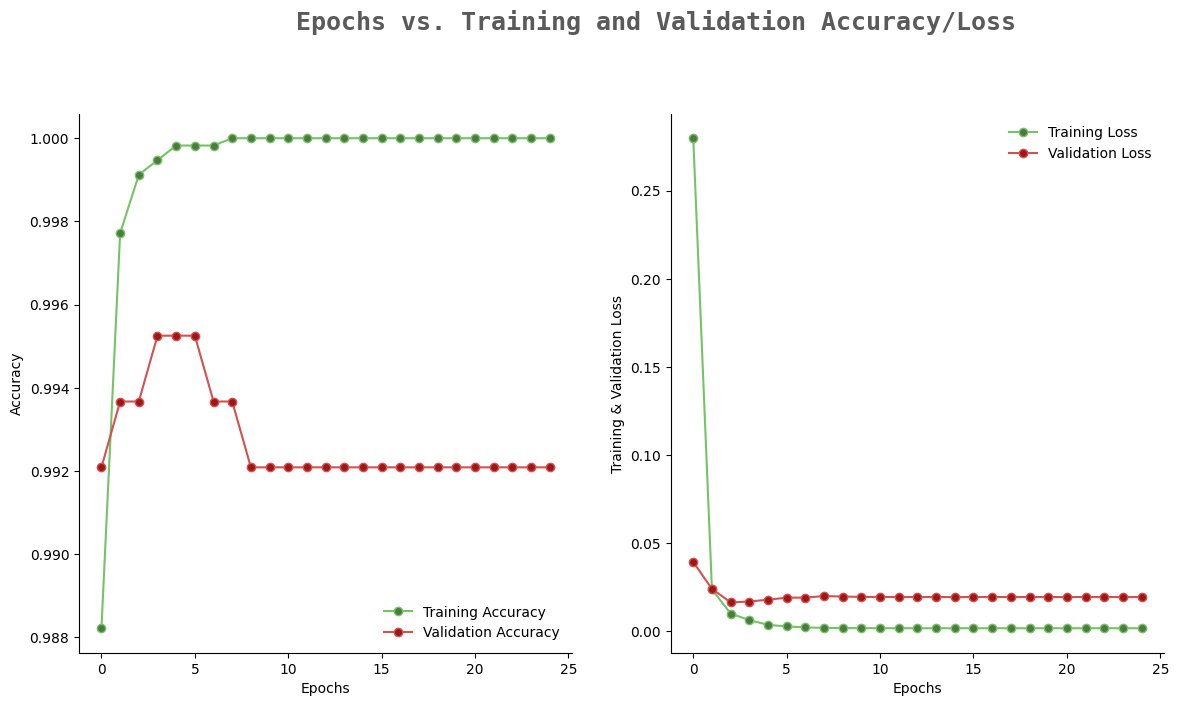

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(25)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

22/22 [==============================] - 17s 404ms/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       170
           1       0.99      1.00      0.99       175
           2       1.00      1.00      1.00       202
           3       1.00      0.99      1.00       156

    accuracy                           1.00       703
   macro avg       1.00      1.00      1.00       703
weighted avg       1.00      1.00      1.00       703



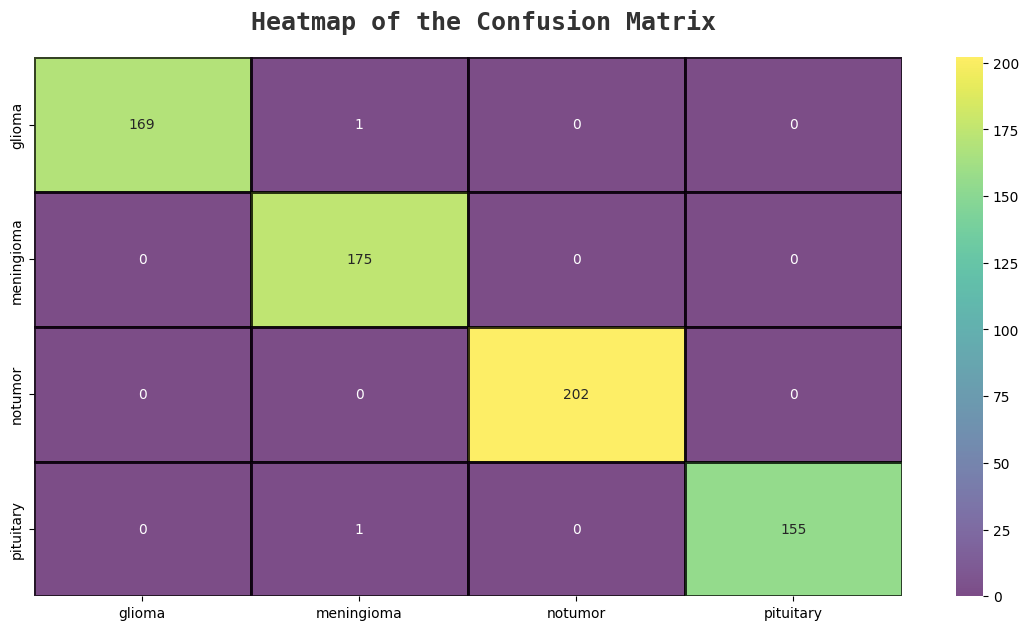

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming pred contains your predicted labels and y_test_new contains the true labels

# Your code for confusion matrix plot
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
cm = confusion_matrix(y_test_new, pred)
sns.heatmap(cm, ax=ax, xticklabels=labels, yticklabels=labels, annot=True,
            cmap='viridis', alpha=0.7, linewidths=2, linecolor='black', fmt='d')  # Use fmt='d' to display integers
fig.text(s='Heatmap of the Confusion Matrix', size=18, fontweight='bold',
         fontname='monospace', color='black', y=0.92, x=0.28, alpha=0.8)
plt.show()


22/22 [==============================] - 3s 125ms/step


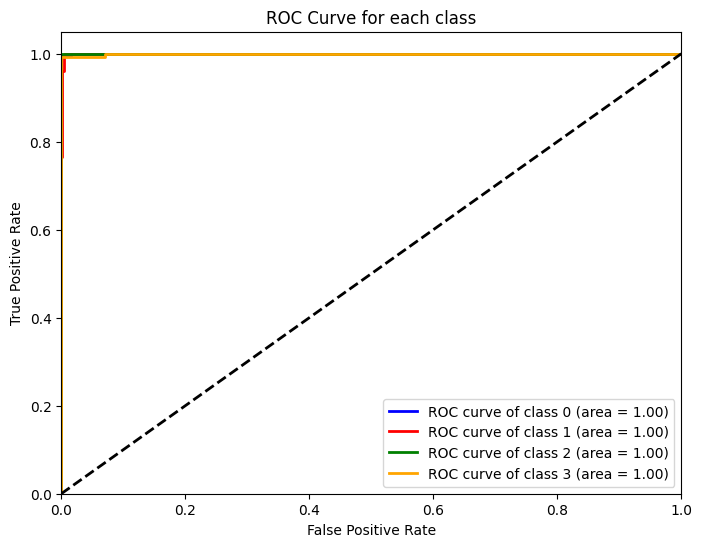

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels
y_test_bin = label_binarize(y_test_new, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]
pred_proba = model.predict(X_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Print classification report
report = classification_report(y_test_new,pred)
print(report)

# Extract accuracy
accuracy = float(report.splitlines()[-5].split()[1])
print(f"Accuracy: {accuracy:.4f}")


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       170
           1       0.99      1.00      0.99       175
           2       1.00      1.00      1.00       202
           3       1.00      0.99      1.00       156

    accuracy                           1.00       703
   macro avg       1.00      1.00      1.00       703
weighted avg       1.00      1.00      1.00       703

Accuracy: 1.0000


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9972


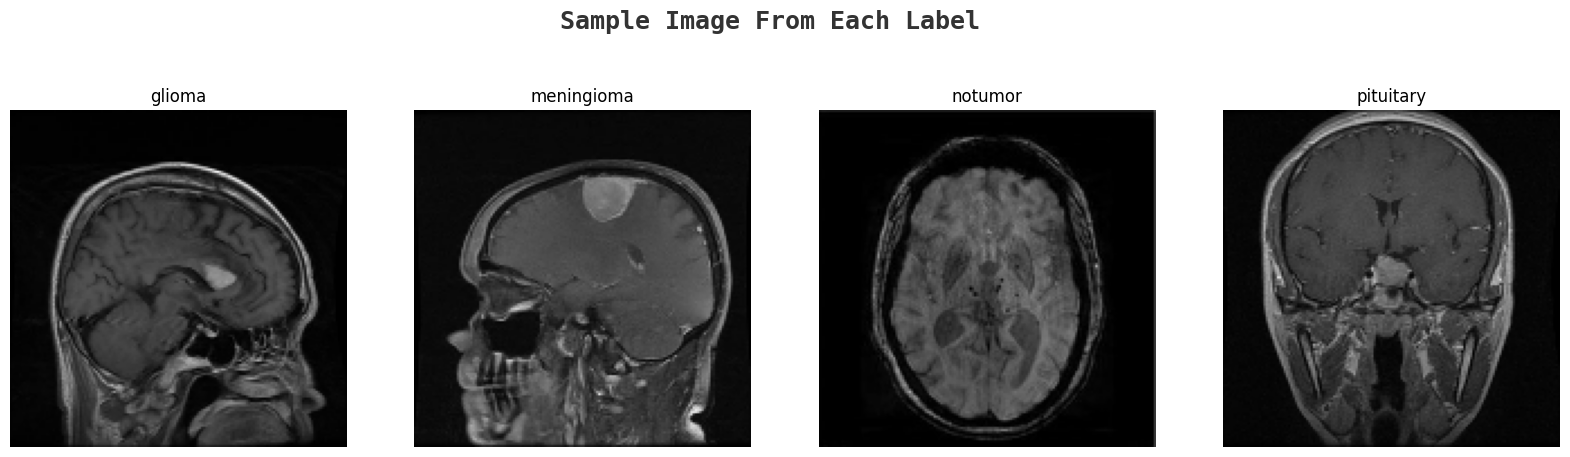

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define paths to the four images
path1 = '/content/Testing/glioma/Te-gl_0259.jpg'
path2 = '/content/Testing/meningioma/Te-me_0053.jpg'
path3 = '/content/Testing/notumor/Te-no_0060.jpg'
path4 = '/content/Testing/pituitary/Te-pi_0080.jpg'

# Initialize lists to store images and labels
X_train = []
y_train = []

# Define image size
image_size = 150

# Iterate over the four paths
for path, label in zip([path1, path2, path3, path4], labels):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size, image_size))
    X_train.append(img)
    y_train.append(label)

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Display the images
fig, ax = plt.subplots(1, 4, figsize=(20, 20))
fig.text(s='Sample Image From Each Label', size=18, fontweight='bold',
             fontname='monospace', y=0.62, x=0.4, alpha=0.8)
for i in range(4):
    ax[i].imshow(X_train[i])
    ax[i].set_title(y_train[i])
    ax[i].axis('off')

plt.show()
